In [22]:
!pip install --upgrade gym==0.25.2

  Using cached gym-0.25.2-py3-none-any.whl
  Attempting uninstall: gym
    Found existing installation: gym 0.25.0
    Uninstalling gym-0.25.0:
      Successfully uninstalled gym-0.25.0


In [23]:
!pip install gym[atari,accept-rom-license]==0.25.0

  Using cached gym-0.25.0-py3-none-any.whl
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


In [24]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import gym
import numpy as np
from collections import deque
import torchvision
import torchvision.transforms as transform

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
class DQN(nn.Module):
  def __init__(self, state_size, action_size, hidden_size):
    super(DQN, self).__init__()

    # define the conv layers
    self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)

    # define the linear layers
    self.fc1 = nn.Linear(3136, 1024)
    self.fc2 = nn.Linear(1024, action_size)

  def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.relu(self.conv2(X))
    X = F.relu(self.conv3(X))
    X = X.view(-1, 3136)
    X = F.dropout(X, p=0.5)
    X = F.relu(self.fc1(X))
    X = F.dropout(X, p=0.2)
    X = self.fc2(X)
    return X

In [27]:
class DQNAgent:
  def __init__(self, state_size, action_size, hidden_size, lr, discount, max_experiences=500000, min_experiences=50000, batch_size=32):
    self.action_size = action_size
    self.dqn = DQN(state_size, action_size, hidden_size).to(device)
    self.target_network = DQN(state_size, action_size, hidden_size).to(device)
    self.target_network.load_state_dict(self.dqn.state_dict())
    self.dqn_optimizer = torch.optim.Adam(self.dqn.parameters(), lr=lr)
    self.discount = discount
    self.replay_buffer = deque()
    self.max_experiences = max_experiences
    self.min_experiences = min_experiences
    self.batch_size = batch_size
    self.resize_function = transform.Resize(size=(84, 84))
    self.grayscale = transform.Grayscale()

  def select_action(self, state, epsilon):
    with torch.no_grad():
      prob = np.random.random()
      if prob < 1 - epsilon:
        return np.random.choice(np.arange(self.action_size))
      else:
        state = state / 255
        state = torch.Tensor(np.array(state)).permute(2, 0, 1).to(device)
        state = self.grayscale(self.resize_function(state)).squeeze(0)
        state_numpy = state.cpu().numpy()
        state = [state_numpy, state_numpy, state_numpy, state_numpy]
        input_state = torch.FloatTensor(np.array(state)).to(device)
        action = torch.argmax(self.dqn(input_state))
        return action

  def add_experience(self, state, action, reward, next_state, done):
    if len(self.replay_buffer) >= self.max_experiences:
      self.replay_buffer.popleft()
    state = torch.Tensor(np.array(state)).permute(2, 0, 1).to(device)
    state = self.grayscale(self.resize_function(state))
    next_state = torch.Tensor(np.array(next_state)).permute(2, 0, 1).to(device)
    next_state = self.grayscale(self.resize_function(torch.Tensor(next_state)))
    self.replay_buffer.append((state, action, reward, next_state, done))

  def train(self):
    if len(self.replay_buffer) < self.min_experiences:
      return

    # randomly select batch
    samples = np.random.randint(4, len(self.replay_buffer) - 1, size=self.batch_size)
    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []

    for sample in samples:
        state = [s for s, _, _, _, _ in self.replay_buffer[sample-3:sample]]
        next_state = [s for s, _, _, _, _ in self.replay_buffer[sample-2:sample+1]]
        _, action, reward, _, done = self.replay_buffer[sample]
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        next_states.append(next_state)
        dones.append(done)

    state_batch = torch.FloatTensor(np.array(states)).to(device)
    next_state_batch = torch.FloatTensor(np.array(next_states)).to(device)
    action_batch = torch.LongTensor(np.array(actions).reshape(-1, 1)).to(device)
    reward_batch = torch.FloatTensor(np.array(rewards).reshape(-1, 1)).to(device)
    done_batch = torch.FloatTensor(1 - np.array(dones).reshape(-1, 1)).to(device)

    with torch.no_grad():
      target_batch = reward_batch + done_batch * self.discount * torch.max(self.dqn(next_state_batch).detach(), dim=1)[0].view(self.batch_size, -1)

    selected_action_prob = self.dqn(state_batch)
    selected_action_prob = selected_action_prob.gather(1, action_batch)
    dqn_loss = nn.HuberLoss()
    dqn_loss_val = dqn_loss(selected_action_prob, target_batch)
    self.dqn_optimizer.zero_grad()
    dqn_loss_val.backward()
    self.dqn_optimizer.step()

    return dqn_loss_val.detach().cpu().numpy()

  def update_target_network(self, num_iters, update_every):
    if num_iters % update_every == 0:
      self.target_network.load_state_dict(self.dqn.state_dict())

In [28]:
env = gym.make("ALE/Breakout-v5")
ACTION_SIZE = env.action_space.n
STATE_SIZE = env.observation_space.shape[0]

In [29]:
# set seed
SEED = 42
env.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

In [30]:
# config
NUM_EPISODE = 30000 # run agent for this many episodes
MIN_EPISODES = 100 # collect data for this many timesteps before training
HIDDEN_SIZE = 64 # number of units in NN hidden layers
LR = 0.0005 # learning rate for optimizer
UPDATE_TARGET_NET_ITER = 5000 # update target network after this many steps
BATCH_SIZE = 64 # mini batch size we train network on
DISCOUNT_RATE = 0.99 # gamma value

EPSILON_START = 1.0 # epsilon start value
EPSILON_MIN = 0.01  # epsilon end value
EPSILON_DECAY_STEPS = NUM_EPISODE * .15 # decay epsilon over this many episodes
EPSILON_STEPS = (EPSILON_START - EPSILON_MIN)/(EPSILON_DECAY_STEPS) # decrement epsilon by this amount every timeste

In [31]:
dqn_agent = DQNAgent(STATE_SIZE, ACTION_SIZE, HIDDEN_SIZE, LR, DISCOUNT_RATE)

In [32]:
stats_rewards_list = []
stats_every = 100
total_reward = 0
timesteps = 0
episode_length = 0
epsilon = EPSILON_START

for episode in range(NUM_EPISODE):
  state = env.reset()
  stats_loss = 0

  while True:
    timesteps += 1
    action = dqn_agent.select_action(state, epsilon)
    next_state, reward, done, _ = env.step(action)
    total_reward += reward
    episode_length += 1


    if done:
      next_state = np.zeros(state.shape)
      reward = -1
      dqn_agent.add_experience(state, action, reward, next_state, done)

      stats_rewards_list.append((episode, total_reward, episode_length))
      total_reward = 0
      episode_length = 0

      epsilon -= EPSILON_STEPS
      epsilon = max(epsilon, EPSILON_MIN)
      if timesteps > MIN_EPISODES and episode % stats_every == 0:
        print('Episode: {}'.format(episode),
              'Timestep: {}'.format(timesteps),
              'Total reward: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[1]),
              'Episode length: {:.1f}'.format(np.mean(stats_rewards_list[-stats_every:],axis=0)[2]),
              'Epsilon: {:.2f}'.format(epsilon),
              f'Loss: {str(stats_loss)}')

      break

    else:
      stats_rewards_list.append((episode, total_reward, episode_length))

    state = next_state
    if timesteps > MIN_EPISODES:
      stats_loss = dqn_agent.train()
      dqn_agent.update_target_network(timesteps, UPDATE_TARGET_NET_ITER)

Episode: 0 Timestep: 2008 Total reward: 0.8 Episode length: 1958.5 Epsilon: 1.00 Loss: None
Episode: 100 Timestep: 113164 Total reward: 0.0 Episode length: 403.5 Epsilon: 0.98 Loss: None
Episode: 200 Timestep: 175307 Total reward: 0.8 Episode length: 383.5 Epsilon: 0.96 Loss: None
Episode: 300 Timestep: 218530 Total reward: 0.0 Episode length: 280.5 Epsilon: 0.93 Loss: None
Episode: 400 Timestep: 256108 Total reward: 0.2 Episode length: 196.5 Epsilon: 0.91 Loss: None
Episode: 500 Timestep: 289565 Total reward: 0.0 Episode length: 217.5 Epsilon: 0.89 Loss: None
Episode: 600 Timestep: 318510 Total reward: 0.0 Episode length: 189.5 Epsilon: 0.87 Loss: None
Episode: 700 Timestep: 345604 Total reward: 2.7 Episode length: 272.5 Epsilon: 0.85 Loss: None
Episode: 800 Timestep: 372073 Total reward: 0.0 Episode length: 257.5 Epsilon: 0.82 Loss: None
Episode: 900 Timestep: 396529 Total reward: 2.0 Episode length: 202.5 Epsilon: 0.80 Loss: None
Episode: 1000 Timestep: 419831 Total reward: 0.0 Epis

Text(0, 0.5, 'Episode Reward')

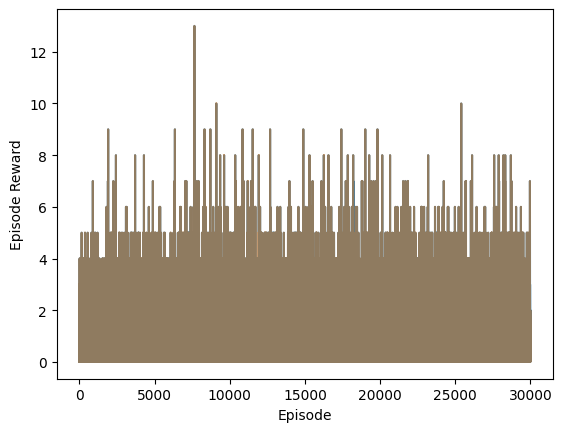

In [33]:
 # plot stats
def get_running_stat(stat, stat_len):
    cum_sum = np.cumsum(np.insert(stat, 0, 0))
    return (cum_sum[stat_len:] - cum_sum[:-stat_len]) / stat_len

episode, r, l = np.array(stats_rewards_list).T
cum_r = get_running_stat(r, 10)
cum_l = get_running_stat(l, 10)

# plot rewards
plt.plot(episode[-len(cum_r):], cum_r)
plt.plot(episode, r, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Reward')

Text(0, 0.5, 'Episode Length')

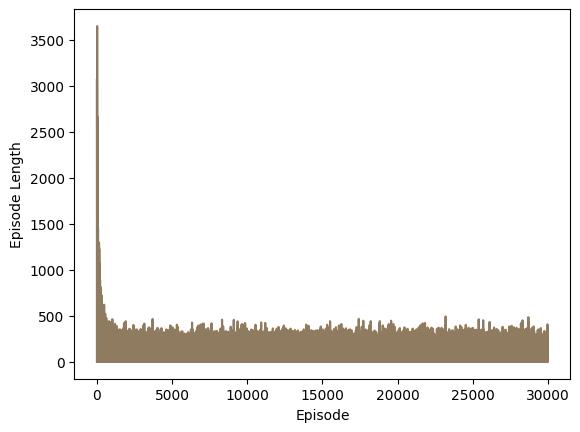

In [34]:
# plot episode lengths
plt.plot(episode[-len(cum_l):], cum_l)
plt.plot(episode, l, alpha=0.5)
plt.xlabel('Episode')
plt.ylabel('Episode Length')